# Potencial no espaço causado por dois condutores usando Elementos Finitos

Date: 2021-02-07  
Author: Pedro H. N. Vieira  
Categories: elementos finitos, potencial, campo elétrico  
Tags: python, fenics, elementos finitos, potencial, campo elétrico  
<!--eofm-->

Determinar o potencial elétrico no espaço dados dois condutores infinitos, cilíndricos e paralelos, $C_1$ e $C_2 $que estejam no potencial $V_1$ e $V_2$, respectivamente.

Este problema já foi [resolvido anteriormente aqui através de mapeamento conforme](https://comp-eletromag.netlify.app/post/potencial_map_conf/). A proposta agora é resolvê-lo com o [Método dos Elementos Finitos (FEM)](https://pt.wikipedia.org/wiki/M%C3%A9todo_dos_elementos_finitos). Para tanto, utilizaremos [Python](https://www.python.org/) e [FEniCS](https://fenicsproject.org/). Assume-se que o leitor tem familiaridade com [Python e seu ecossistema para computação científica](https://www.scipy.org/) além de [Equações Diferenciais Parciais (PDE)](https://pt.wikipedia.org/wiki/Equa%C3%A7%C3%A3o_diferencial_parcial) tais como equações de Laplace e de Poisson. Python é bem fácil de aprender e para o leitor que deseja isto, recomenda-se o [tutorial oficial de Python (em português BR)](https://docs.python.org/pt-br/3/tutorial/) e, em especial, o [Scipy Lecture Notes (em inglês)](http://scipy-lectures.org/index.html).

O pessoal do FEniCS publicou alguns livros eletrônicos disponíveis de graça (em inglês): [Solving PDEs in Python](https://www.springer.com/gp/book/9783319524610) e [Automated Solution of Differential Equations by the Finite Element Method](https://launchpadlibrarian.net/83776282/fenics-book-2011-10-27-final.pdf). Uma nota final: o projeto FEniCS começou em 2003 e, atualmente, tem uma [versão experimental (DOLFINx)](https://github.com/FEniCS/dolfinx/) que pretende ser uma sucessora da versão atual. [Há um tutorial para os interessados](https://jorgensd.github.io/dolfinx-tutorial/). Aqui usaremos a [versão clássica](https://fenicsproject.org/tutorial/) do [DOLFIN](https://fenicsproject.org/olddocs/dolfin/1.5.0/python/index.html).

Infelizmente, a documentação do FEniCS deixa muito a desejar. É comum que algumas funcionalidades de interesse tenham a documentação pouco descritiva ou inexistente; e que os exemplos encontrados na internet não funcionem. Ainda assim, a melhor maneira de simular um caso é procurar exemplos e adaptá-los. Alguns sites que eu encontrei que podem ser um ponto de partida:

- https://comphysblog.wordpress.com/
- https://fenicsproject.discourse.group/t/from-the-electric-field-between-two-conductors-the-resulting-total-force/2792/2
- https://scicomp.stackexchange.com/questions/7378/fenics-how-to-specify-boundary-conditions-on-a-circle-inside-2d-mesh
- https://people.math.sc.edu/Burkardt/fenics_src/fenics_src.html

## Equação a ser resolvida
A equação a ser resolvida é a de Laplace no plano excluindo-se as regiões dentro dos condutores.

$$
\nabla^2 u = 0
$$

Sejam dois círculos, $C_1$ e $C_2$ com raio $R_1$ e $R_2$ , respectivamente, tal que $R_1 \ge R_2$ . Assuma ainda que $C_1$ está centrado na origem do plano complexo e $C_2$ centrado sobre o eixo Real no ponto $h$ tal que $h > R_1 + R_2$.

O primeiro passo é colocar o problema na forma variacional. Utilizaremos a equação de Poisson com condições de fronteira como exemplo, onde $\mathbf{x}$ é o vetor posição no espaço $\mathbb{R}^N$, $u$ é a função que se deseja determinar (chamada função tentativa, *trial*), $f$ é a função forçante (fonte), $\Omega$ é o domínio de interesse e $\partial \Omega$ é seu contorno (fronteira).

\begin{aligned}
-\nabla^2 u(\mathbf{x}) &= f(\mathbf{x}) \qquad \mathbf{x} \in \Omega \\
u(\mathbf{x}) &= u_D(\mathbf{x}) \qquad \mathbf{x} \in \partial \Omega \\
\end{aligned}

Multiplicamos esta equação por uma função teste $v(\mathbf{x})$ que desaparece (vai a zero) na fronteira $\partial \Omega$ onde $u$ é conhecida e integramos o resultado no domínio $\Omega$. A seguir, "$(\mathbf{x})$" será suprimido por simplicidade.

$$
-\int_\Omega(\nabla^2 u) \, v\,\text{d}\mathbf{x} = \int_\Omega f\, v \,\text{d}\mathbf{x}
$$

Faz-se integração por partes, onde $\vec n$ é o vetor unitário normal (para fora) à fronteira:

$$
-\int_\Omega (\nabla^2 u) \, v\,\text{d}\mathbf{x} = \int_\Omega \nabla u \cdot \nabla v\,\text{d}\mathbf{x} - \int_{\partial \Omega} (\nabla u \cdot \vec n) \,v \,\text{d}s
$$

Pela condição de $v$ desaparecer na fronteira, sabemos que o segundo termo é nulo, portanto:

$$
\int_\Omega \nabla u \cdot \nabla v\,\text{d}\mathbf{x} = \int_\Omega f\, v \,\text{d}\mathbf{x}
$$

A notação canônica para problemas variacionais é:

$$
a(u,v) = L(v)
$$

Onde agrupam-se os termons desconhecidos em $a(u,v)$, chamada de forma bilinear, e o termos conhecidos em $L(v)$, chamada de forma linear. No caso da equação de Poisson acima:

\begin{aligned}
a(u,v) &= \int_\Omega \nabla u \cdot \nabla v\,\text{d}\mathbf{x} \\
L(v) &= \int_\Omega f\, v \,\text{d}\mathbf{x} \\
\end{aligned}

In [1]:
import numpy as np
from numpy import cos, sin, abs, real, conj, mean, log
import fenics as fn
import dolfin
import mshr
from scipy.constants import pi
from scipy.optimize import fsolve
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 100

# Parâmetros
R1 = 4.5  # raio do condutor 1
R2 = 2.0  # raio do condutor 2
h = 12.0  # separação entre os condutores
assert R1 >= R2 and h > R1 + R2  # teste de sanidade das hipóteses
u1 = 1/2  # potencial no condutor 1
u2 = -1/2  # potencial no condutor 2

Voltando ao problema em questão, na forma variacional:

\begin{aligned}
\int_\Omega \nabla u \cdot \nabla v\,\text{d}\mathbf{x} = 0 \qquad &\mathbf{x} \in \Omega \\
u(\mathbf{x}) = U_1 \qquad &\mathbf{x} \in C_1 \\
u(\mathbf{x}) = U_2 \qquad &\mathbf{x} \in C_2 \\
\end{aligned}

Onde o domínio $\Omega$ é o plano $\mathbb{R}^2$ exceto as regiões dentro dos condutores.

$$
\Omega = \mathbb{R}^2 - (C_1 \cup C_2)
$$

Este domínio $\Omega$ tem uma área infinita. Portanto, deve-se truncá-lo procurando-se um equilíbrio entre volume e recursos computacionais, pois um domínio maior exigirá mais tempo e memória, contudo terá uma solução mais próxima da verdadeira.

O código consiste em criar um retângulo e tirar dele as regiões dentro dos condutores e, então, gerar a malha.

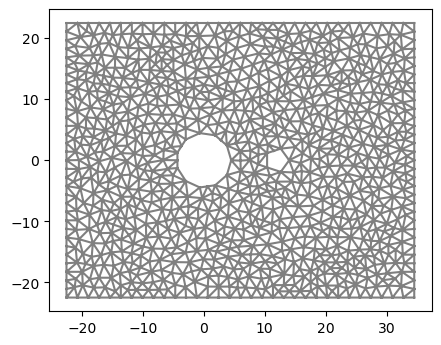

In [2]:
x0 = -R1 * 5
y0 = -R1 * 5
x1 = -x0 + h
y1 = -y0
retangulo = mshr.Rectangle(dolfin.Point(x0,y0), dolfin.Point(x1,y1))
c1 = mshr.Circle(dolfin.Point(0,0), R1)
c2 = mshr.Circle(dolfin.Point(h,0), R2)
domain = retangulo - c1 - c2
resolucao = 25
mesh = mshr.generate_mesh(domain, resolucao)
fn.plot(mesh)

Depois é necessário definir ou marcar as fronteiras $\partial \Omega$ onde $u(\mathbf{x})$ é conhecido. Para tanto, define-se uma classe de subdomínio com um método `inside` para determinar se um ponto está dentro ou não dele. É boa prática ter uma tolerância, pois nem sempre a malha tem pontos exatamente sobre a fronteira.

Para testar se a definição das fronteiras deu certo, pode-se criar uma função tentativa, aplicar um valor nas fronteiras e plotar.

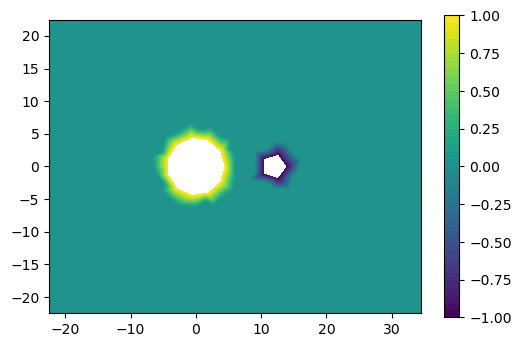

In [3]:
class Condutor1(fn.SubDomain):
    def inside(self, x, on_boundary):
        tol = 1e-9
        return on_boundary and np.linalg.norm(x) <= R1 + tol
    
class Condutor2(fn.SubDomain):
    def inside(self, x, on_boundary):
        tol = 1e-9
        return on_boundary and np.linalg.norm(x - [h, 0]) <= R2 + tol

# teste das fronteiras
V = fn.FunctionSpace(mesh, "CG", 1)  # define espaço funcional
u = fn.Function(V)  # função tentativa

bc1 = fn.DirichletBC(V, fn.Constant(1), Condutor1())
bc1.apply(u.vector())

bc2 = fn.DirichletBC(V, fn.Constant(-1), Condutor2())
bc2.apply(u.vector())

c = fn.plot(u)
plt.colorbar(c)
plt.show()

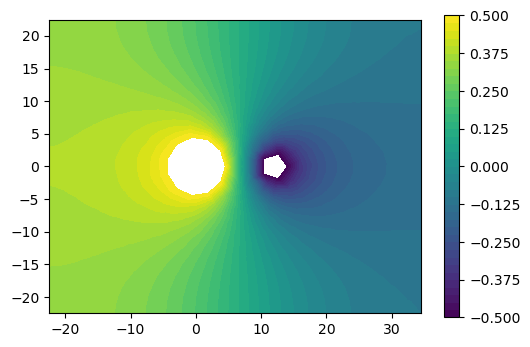

In [4]:
# Definir problema variacional e aplicar condições de fronteira
V = fn.FunctionSpace(mesh, "CG", 1)  # define espaço funcional
u = fn.TrialFunction(V)
v = fn.TestFunction(V)
f = fn.Constant(0.0)
a = fn.dot(fn.grad(u), fn.grad(v)) * fn.dx
L = f * v * fn.dx

# Aplicar condições de fronteira
u = fn.Function(V)
bc1 = fn.DirichletBC(V, u1, Condutor1())
bc2 = fn.DirichletBC(V, u2, Condutor2())
bcs = [bc1, bc2]

fn.solve(a == L, u, bcs)
c = fn.plot(u)
plt.colorbar(c)
plt.show()

# Exportar a solução como um arquivo VTK
vtkfile = fn.File('potenciais.pvd')
vtkfile << u

Plotar as linhas de campo Elétrico é bem direto:

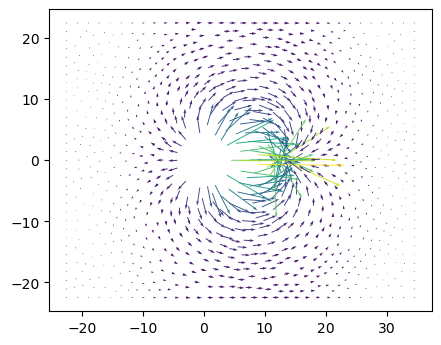

In [5]:
E = fn.project(-fn.grad(u))
fn.plot(E)

Potemos exportar os dados da solução para serem renderizados num programa externo, tal como o [Paraview](https://www.paraview.org/) ou [Mayavi](https://docs.enthought.com/mayavi/mayavi/index.html). Um formato comumente utilizados por este tipo de programa é o VTK. A imagem abaixo foi criada com o Paraview.

![potenciais1](potenciais1.png)

Se repararmos nas linhas equipotenciais, vemos que elas não formam elipses, como esperado neste tipo de problema (ele é essencialmente igual a um dipolo elétrico). Isto ocorreu por causa do truncamento do domínio do problema e por termos deixado o valor do potencial indefinido no contorno dele. Podemos definir mais uma condição de contorno estabelecendo que o potencial deve ser nulo fora do domínio da solução.

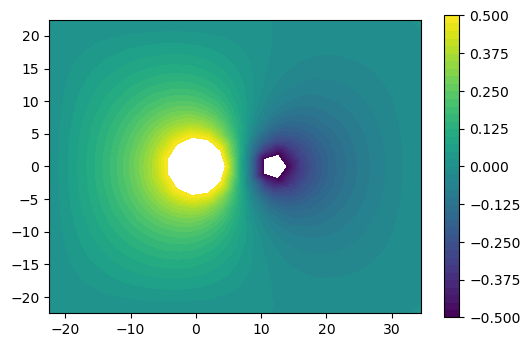

In [6]:
class Bordas(fn.SubDomain):
    def inside(self, x, on_boundary):
        tol = 1e-9
        c1 = fn.near(x[0], x0) or fn.near(x[0], x1)
        c2 = fn.near(x[1], y0) or fn.near(x[1], y1)
        return on_boundary and (c1 or c2)
    
# Definir problema variacional e aplicar condições de fronteira
V = fn.FunctionSpace(mesh, "CG", 1)  # define espaço funcional
u = fn.TrialFunction(V)
v = fn.TestFunction(V)
f = fn.Constant(0.0)
a = fn.dot(fn.grad(u), fn.grad(v)) * fn.dx
L = f * v * fn.dx

# Compute solution
u = fn.Function(V)
bc1 = fn.DirichletBC(V, u1, Condutor1())
bc2 = fn.DirichletBC(V, u2, Condutor2())
bc3 = fn.DirichletBC(V, fn.Constant(0), Bordas())
bcs = [bc1, bc2, bc3]
fn.solve(a == L, u, bcs)
c = fn.plot(u)
plt.colorbar(c)
plt.show()

O formato dos potenciais ficaram mais próximos do esperado, mas ainda ficam distorcidos, pois o domínio ainda está truncado. Algo que pode ser feito para problemas harmônicos (satisfazem equação de Laplace) no $\mathbb{R}^2$ é um mapeamento conforme (onde todos os ângulos locais são preservados) do domínio de uma geometria infinita e complicada para algo mais simples. Exemplos disto são o [Mapeamento de Schwarz-Christoffel](https://en.wikipedia.org/wiki/Schwarz%E2%80%93Christoffel_mapping) e a [Transformação de Möbius](https://en.wikipedia.org/wiki/M%C3%B6bius_transformation).

## Domínio Transformado

No problema em questão, pode-se encadear transformações de Möbius para mapear o domínio fora dos condutores na região entre dois anéis concêntricos. Os detalhes serão omitidos, mas podem ser encontrados [neste post](https://comp-eletromag.netlify.app/post/potencial_map_conf/). Resolve-se o problema no domínio transformado e aplica-se a transformada inversa sobre a função potencial para se obter a resposta no domínio original. É uma situação similar ao uso da Transformada de Laplace.

O potencial $u$ num ponto $\mathbf{x}$ do domínio original é obtido da seguinte maneira, onde $u_T$ é o potencial no domínio transformado:

$$
u(\mathbf{x}) = T^{-1}\left (\, u_T(\,T(\mathbf{x})\,) \,\right )
%u(\mathbf{x}) = (T^{-1} \circ u_T \circ T) (\mathbf{x})
$$

In [7]:
def find_trans(r1, r2, h, n=10):
    """
    Acha a transformação que mapeia a área disjunta de dois discos de raios
    r1 e r2 num anel centrado na origem. Considera-se r1 >= r2 e que o disco
    de raio r1 está centrado na origem e o disco de raio r2 centrado no ponto h.

    Retorna
    -------
        T : a transformação T
        Ti : a transformação inversa
        params : tupla dos parâmetros (p, xi1, xi2)
    """
    if r1 < r2:
        raise ValueError("r1 < r2")
        
    if h < r1 + r2:
        raise ValueError("h < r1 + r2")
        
    theta = np.linspace(0, 2*pi, n)
    z1 = r1 * (cos(theta) + 1j * sin(theta))
    z2 = r2 * (cos(theta) + 1j * sin(theta)) + h
    # transforma o círculo maior numa linha sobre o eixo imaginário
    def f(z):
        return (r1 + z) / (r1 - z)
    
    # centrar o círculo C2 transformado na origem
    w1 = f(z2[0])
    w2 = f(z2[int(np.ceil(n / 2))])
    def eq(x):
        e1 = abs(w1)**2 - 2 * real(w1 * conj(x[0])) + abs(x[0])**2 - x[1]**2
        e2 = abs(w2)**2 - 2 * real(w2 * conj(x[0])) + abs(x[0])**2 - x[1]**2
        return [e1, e2]
    
    p, r = fsolve(eq, [0.0, 2 * r1])
    # transforma a linha num círculo centrado na origem,
    # enquanto preserva o centro do outro círculo na origem também
    # x1 e x2 são pontos simétricos a ambos linha e círculo
    x1, x2 = np.roots([1, 2*p, r**2])
    if x1 > x2:
        x1, x2 = x2, x1  # FIXME raízes trocadas leva a resultado "esquisito"
        
    # Transformação de Möbius equivalente
    def T(z):
        return (r1*(p + x1 + 1) - z*(p + x1 - 1))/(r1*(p + x2 + 1) - z*(p + x2 - 1))
    
    def Ti(z):
        return r1*((p + x1 + 1) - z*(p + x2 + 1))/((p + x1 - 1) - z*(p + x2 - 1))
    
    return T, Ti, (p, x1, x2)

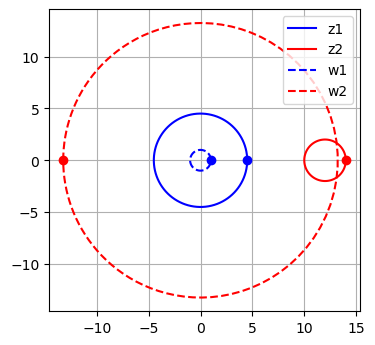

In [8]:
# Transformação dos condutores
n = 100
theta = np.linspace(0, 2*pi, n)
zc1 = R1 * (cos(theta) + 1j * sin(theta))
zc2 = R2 * (cos(theta) + 1j * sin(theta)) + h
T, Ti, params = find_trans(R1, R2, h)
w1 = T(zc1)
w2 = T(zc2)
zc1 = Ti(w1)  # pra confirmar que a inversa está correta
zc2 = Ti(w2)

fig, ax = plt.subplots()
ax.set_aspect('equal')
ax.grid()
ax.plot(zc1.real, zc1.imag, 'b-', label="z1")
ax.plot(zc2.real, zc2.imag, 'r-', label="z2")
ax.plot(w1.real, w1.imag, 'b--', label="w1")
ax.plot(w2.real, w2.imag, 'r--', label="w2")
ax.plot(zc1.real[0], zc1.imag[0], 'ob')
ax.plot(zc2.real[0], zc2.imag[0], 'or')
ax.plot(w1.real[0], w1.imag[0], 'ob')
ax.plot(w2.real[0], w2.imag[0], 'or')
ax.legend()
plt.show()

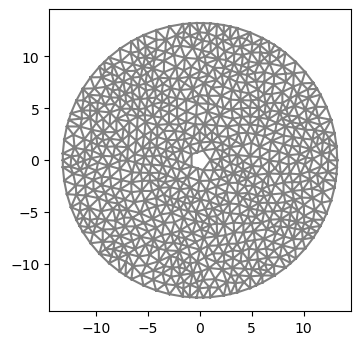

raio interno = 1.0
raio externo = 13.229969591956051


In [9]:
# definir domínio
raio_interno = np.abs(w1[0])
raio_externo = np.abs(w2[0])
cinterno = mshr.Circle(dolfin.Point(0,0), raio_interno)
cexterno = mshr.Circle(dolfin.Point(0,0), raio_externo)
domain = cexterno - cinterno
resolucao = 20
mesh = mshr.generate_mesh(domain, resolucao)
fn.plot(mesh)
plt.show()
print("raio interno =", raio_interno)
print("raio externo =", raio_externo)

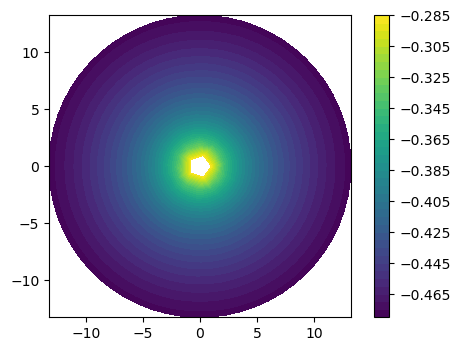

T(u1) = -0.28892971407238927
T(u2) = -0.47811794962593374


In [10]:
class Interno(fn.SubDomain):
    def inside(self, x, on_boundary):
        tol = 1e-15
        return on_boundary and np.linalg.norm(x) <= raio_interno + tol

class Externo(fn.SubDomain):
    def inside(self, x, on_boundary):
        tol = 1e-15
        c = raio_interno + tol <= np.linalg.norm(x) <= raio_externo + tol
        return on_boundary and c

# Definir problema variacional e aplicar condições de fronteira
V = fn.FunctionSpace(mesh, "CG", 1)  # define espaço funcional
u = fn.TrialFunction(V)
v = fn.TestFunction(V)
f = fn.Constant(0.0)
a = fn.dot(fn.grad(u), fn.grad(v)) * fn.dx
L = f * v * fn.dx

# Compute solution
u = fn.Function(V)
bc1 = fn.DirichletBC(V, T(u1), Interno())
bc2 = fn.DirichletBC(V, T(u2), Externo())
fn.solve(a == L, u, [bc1, bc2])
c = fn.plot(u)
plt.colorbar(c)
plt.show()

print("T(u1) =", T(u1))
print("T(u2) =", T(u2))

## Domínio Original

Para obter a resposta no domínio original, precisamos definir um conjunto de pontos, mapeá-los no domínio resolvido com FEM, obter o potencial no domínio transformado e aplicar a transformada (mapa) inversa nele.

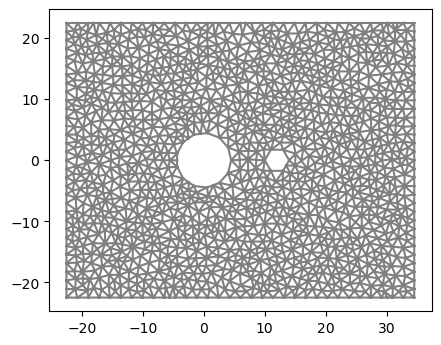

In [11]:
x0 = -R1 * 5
y0 = -R1 * 5
x1 = -x0 + h
y1 = -y0
retangulo = mshr.Rectangle(dolfin.Point(x0,y0), dolfin.Point(x1,y1))
c1 = mshr.Circle(dolfin.Point(0,0), R1)
c2 = mshr.Circle(dolfin.Point(h,0), R2)
domain = retangulo - c1 - c2
resolucao = 30
mesh_original = mshr.generate_mesh(domain, resolucao)
fn.plot(mesh_original)

In [12]:
# permitir extrapolação, caso o ponto transformado esteja fora do domínio da função
u.set_allow_extrapolation(True)

def potencial(z):
    """Calcula o potencial no ponto z do domínio original."""
    w = T(z[0] + z[1]*1j)
    ponto = fn.Point(w.real, w.imag)
    p = Ti( u(ponto) )
    # mascarar valores extrapolados
    if u1 < u2:
        m0 = u1
        m1 = u2
    else:
        m0 = u2
        m1 = u1
    if p < m0:
        p = m0
    elif p > m1:
        p = m1
        
    return p
    
pontos = mesh_original.coordinates()
valores = np.apply_along_axis(potencial, 1, pontos)

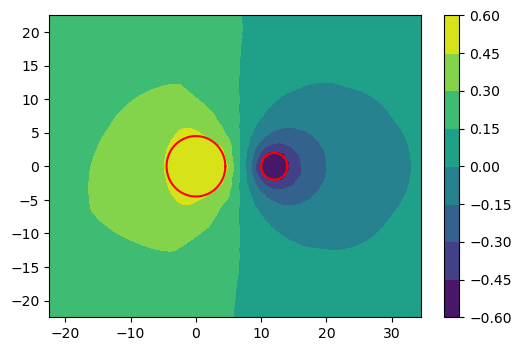

In [13]:
c = plt.tricontourf(pontos[:,0], pontos[:,1], valores)#, levels=np.linspace(-0.5, 0.5, 15))
plt.plot(zc1.real, zc1.imag, 'r-')
plt.plot(zc2.real, zc2.imag, 'r-')
plt.colorbar(c)
plt.show()

## Malha Refinada

A resolução não ficou tão boa próximo do condutor 1 (esquerda). Para melhorar, é necessário resolver o problema no domínio transformado usando uma malha mais refinada perto das fronteiras, especialmente perto do círculo interno que são onde os pontos perto do condutor $C_1$ são mapeados.

O módulo de criar malhas do FEniCS, o mshr, é limitado em suas capacidades e não é mais mantido. Portanto, muito código que o utiliza ficou obsoleto. É recomendado usar um programa externo para criar malhas mais complexas e refinadas, tal como o [Gmsh](https://gmsh.info/). Utilizaremos a interface [pygmsh](https://pypi.org/project/pygmsh/).

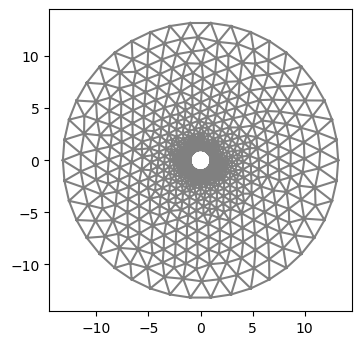

In [14]:
import pygmsh
with pygmsh.occ.Geometry() as geom:
    geom.characteristic_length_max = 2.0
    disco_interno = geom.add_disk([0, 0], raio_interno)
    disco_externo = geom.add_disk([0, 0], raio_externo)
    geom.boolean_difference(disco_externo, disco_interno)
    # refinar a malha:
    field0 = geom.add_boundary_layer(
        edges_list=[disco_interno],
        nodes_list=[disco_interno],
        lcmin=0.1,
        lcmax=2.0,
        distmin=0.1,
        distmax=2.0,
    )
    geom.set_background_mesh([field0], operator="Min")
    mesh = geom.generate_mesh()
    mesh.prune_z_0()  # deixar a malha 2D

#mesh.write("mesh.xdmf")  # para ser lido pelo paraview
mesh.write("mesh.xml")  # para ser lido pelo dolfin (fenics)
mesh = fn.Mesh("mesh.xml")
fn.plot(mesh)

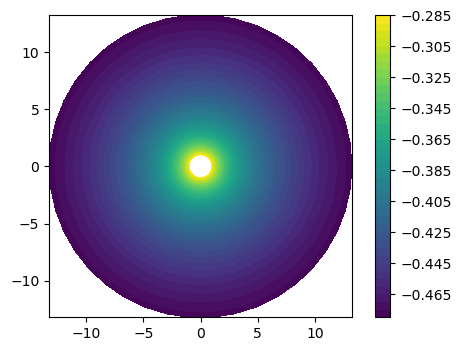

T(u1) = -0.28892971407238927
T(u2) = -0.47811794962593374


In [15]:
# Definir problema variacional e aplicar condições de fronteira
V = fn.FunctionSpace(mesh, "CG", 1)  # define espaço funcional
u = fn.TrialFunction(V)
v = fn.TestFunction(V)
f = fn.Constant(0.0)
a = fn.dot(fn.grad(u), fn.grad(v)) * fn.dx
L = f * v * fn.dx

# Compute solution
u = fn.Function(V)
bc1 = fn.DirichletBC(V, T(u1), Interno())
bc2 = fn.DirichletBC(V, T(u2), Externo())
fn.solve(a == L, u, [bc1, bc2])
if True:  # omitir plot
    c = fn.plot(u)
    plt.colorbar(c)
    plt.show()

    print("T(u1) =", T(u1))
    print("T(u2) =", T(u2))

Então criamos um grid de pontos no domínio original e calculamos potencial e o campo elétrico (numericamente com o numpy):

In [16]:
# permitir extrapolação, caso o ponto transformado esteja fora do domínio da função
u.set_allow_extrapolation(True)

def potencial(z):
    """Calcula o potencial no ponto z do domínio original."""
    w = T(z[0] + z[1]*1j)
    ponto = fn.Point(w.real, w.imag)
    p = Ti( u(ponto) )
    # mascarar valores extrapolados
    if u1 < u2:
        m0 = u1
        m1 = u2
    else:
        m0 = u2
        m1 = u1
    if p < m0:
        p = m0
    elif p > m1:
        p = m1
        
    return p
    
def potencial2(x, y): return potencial([x, y])
potencial2_vec = np.vectorize(potencial2)
nx = ny = 35
X, Y = np.meshgrid(np.linspace(x0, x1, nx), np.linspace(y0, y1, ny))
pot = potencial2_vec(X, Y)
Ey, Ex = np.gradient(-pot)

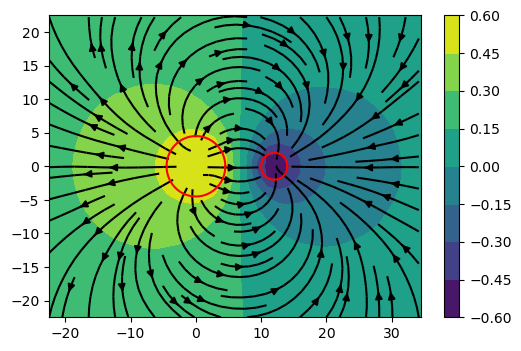

In [17]:
plt.streamplot(X, Y, Ex, Ey, color='k')
plt.plot(zc1.real, zc1.imag, 'r-')
plt.plot(zc2.real, zc2.imag, 'r-')
c = plt.contourf(X, Y, pot)
plt.colorbar(c)
plt.show()